In [29]:
import os
from dotenv import load_dotenv, find_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage,RemoveMessage
from langgraph.graph import START, StateGraph, END, MessagesState
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.errors import NodeInterrupt
from typing import Dict
from langgraph.types import interrupt, Command
from datetime import date





load_dotenv(find_dotenv())
os.environ["LANGCHAIN_PROJECT"] = "ex_module-3"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite",temperature=0)

# Introduction to LangGraph - Module 3 exercises

## Goals:
Again, we're going to practise what we've been learning during Module 3.
- We'll start by making a baseline graph with components from previous modules. It will be used throughout this block **(?)** of exercises.
- We'll divide the tools into two sections: those that the model can use directly, and those that need a human supervision.
- We'll also correct some of the information as a final user.
- And, finally, we'll practise a little of time-travelling, by consulting the history of the states **(?)** and forking it into a new process.


### 1.- Make a graph that can summarize the conversation when there are 3 messages or more, in the same fashion as in module 2:

Use the same initial list of messages as a starting point and add/modify as needed for the tests.

In [30]:
messages = [
    {"role": "user", "content": "Hello", "notes": None},
    {"role": "ai", "content": "Good morning, how are you?", "notes": None},
    {"role": "user", "content": "Ok", "notes": "The user says they're ok"},
    {"role": "ai", "content": "Perfect, thank you!", "notes": None},
    {"role": "user", "content": "Can you help me with a problem?", "notes": "User requests assistance"},
    {"role": "ai", "content": "Of course! What can I help you with?", "notes": None},
    {"role": "user", "content": "I'm having trouble with my code", "notes": "User mentions coding issues"},
    {"role": "ai", "content": "I'll be happy to help. Can you describe the problem?", "notes": None},
    {"role": "user", "content": "It's about Python loops", "notes": "User specifies Python loops as the topic"}
]

In [31]:
def decide_trimmer(state: MessagesState):
    if len(state['messages']) > 3:
        return "summarizator"
    else:
        return "answerer"
    
def summarizer(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][0:]]
    response = model.invoke(f"Make a summary of the following conversation: {state["messages"]}")
    return {'messages': delete_messages + [response.content]}

def answerer(state: MessagesState):
    response = model.invoke(state['messages'])
    return {'messages': response.content}

In [32]:
builder = StateGraph(MessagesState)
builder.add_node("summarizator", summarizer)
builder.add_node("answerer", answerer)
builder.add_conditional_edges(START, decide_trimmer, {"summarizer":"summarizator","answerer":"answerer" })
builder.add_edge("summarizator","answerer")
builder.add_edge("answerer",END)
graph = builder.compile()
# display(Image(graph.get_graph().draw_mermaid_png()))

#### 1.1.- Include also one of the API tools created in module 1. Ensure everything works

Key 'title' is not supported in schema, ignoring


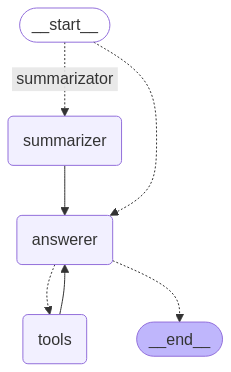

In [33]:
### I've decided to use Tavily, it is simpler. Also I made some tuning of the model, so it retrieves more relevant info.

def get_news(city: str) -> Dict:
    '''
    Tool to get the latest news about a given city.
    
    Args:
        city (str): Name of the city
        
    Returns:
        Dict: Latest news about the city
    '''
    today = date.today().strftime("%Y-%m-%d")
    search = TavilySearchResults(max_results=4,include_answer=True)
    return search.invoke({"query":f"Make a summary of the news of {today} about the city of {city}. Include the urls of the sources","time_range":"day","include_answer":"basic"})

tools = [get_news]
model_with_tools = model.bind_tools(tools)

def answerer_tools(state: MessagesState): ### As we've made a new version of the model, we need to use that one
    response = model_with_tools.invoke(state['messages'])
    return {'messages': response}

builder = StateGraph(MessagesState)
builder.add_node("summarizer", summarizer)
builder.add_node("answerer", answerer_tools)
builder.add_node("tools", ToolNode(tools))
builder.add_conditional_edges(START, decide_trimmer, {"summarizator":"summarizer","answerer":"answerer" })
builder.add_conditional_edges("answerer",tools_condition)
builder.add_edge("summarizer","answerer")
builder.add_edge("tools","answerer")
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))



##### Test 1: Summarizing the original convo

In [34]:
graph.invoke({"messages":messages})

{'messages': [HumanMessage(content='The conversation begins with greetings. The AI asks how the user is, and the user responds that they are "ok." The AI then offers assistance. The user asks for help with a problem, specifically with their code. The AI offers to help and asks for a description of the problem. The user clarifies that the problem is related to Python loops.', additional_kwargs={}, response_metadata={}, id='17ab5512-4650-49df-a650-7eb63b84b9e7'),
  AIMessage(content='I am here to help. Can you describe the problem you are encountering with your Python loops?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-3ccae5b2-7469-4d0a-8329-1b93eb367e1e-0', usage_metadata={'input_tokens': 147, 'output_tokens': 20, 'total_tokens': 167, 'input_token_details': {'cache_read': 0}})]}

##### Test 2: Using the news tool

In [35]:
messages = [
    {"role": "user", "content": "Hello", "notes": None},
    {"role": "ai", "content": "Good morning, how are you?", "notes": None},
    {"role": "user", "content": "Ok", "notes": "The user says they're ok"},
    {"role": "ai", "content": "Perfect, thank you!", "notes": None},
    {"role": "user", "content": "Can you help me with a problem?", "notes": "User requests assistance"},
    {"role": "ai", "content": "Of course! What can I help you with?", "notes": None},
    {"role": "user", "content": "What are the latest news about Madrid?", "notes": "User mentions coding issues"}
]

In [36]:
graph.invoke({"messages":messages})

{'messages': [HumanMessage(content='The conversation starts with greetings. The AI asks how the user is, and the user responds that they are "ok". The AI then expresses its satisfaction. The user then asks for help with a problem. The AI offers assistance, and the user asks for the latest news about Madrid.', additional_kwargs={}, response_metadata={}, id='2dde3803-5889-4329-9ccf-07756ba62b44'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_news', 'arguments': '{"city": "Madrid"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9f2df901-035e-4116-a498-8ba9a9010074-0', tool_calls=[{'name': 'get_news', 'args': {'city': 'Madrid'}, 'id': '776307c7-9dc4-4289-a954-2207c86cca14', 'type': 'tool_call'}], usage_metadata={'input_tokens': 134, 'output_tokens': 5, 'total_tokens': 139, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{"title": "[PDF] CITY OF MADR

##### Test 3: News tool, no summarizer

In [37]:
no_sum_messages = [
    # {"role": "user", "content": "Hello", "notes": None},
    # {"role": "ai", "content": "Good morning, how are you?", "notes": None},
    # {"role": "user", "content": "Ok", "notes": "The user says they're ok"},
    # {"role": "ai", "content": "Perfect, thank you!", "notes": None},
    # {"role": "user", "content": "Can you help me with a problem?", "notes": "User requests assistance"},
    # {"role": "ai", "content": "Of course! What can I help you with?", "notes": None},
    {"role": "user", "content": "What are the latest news about Madrid?", "notes": "User mentions coding issues"}
]

In [38]:
graph.invoke({"messages":no_sum_messages})

{'messages': [HumanMessage(content='What are the latest news about Madrid?', additional_kwargs={'notes': 'User mentions coding issues'}, response_metadata={}, id='04eeca0b-6797-4e92-8171-bb1b1c552e1c'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_news', 'arguments': '{"city": "Madrid"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-557e8ba1-5d1a-4e1a-a197-d9510119e110-0', tool_calls=[{'name': 'get_news', 'args': {'city': 'Madrid'}, 'id': '181fd57c-fa58-43cf-bc44-c3d2eb0e977d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 85, 'output_tokens': 5, 'total_tokens': 90, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{"title": "[PDF] CITY OF MADRID PRESS DOSSIER", "url": "https://www.madrid-destino.com/sites/default/files/2025-01/DossierPrensa_ingles_2025.pdf", "content": "It contains special content on re- sources available in the city, in

### 2.- Modify it so it streams the tokens of the messages. Does the core code of the graph change?

In [39]:
### Example for streaming whole messages
for chunk in graph.stream({"messages":messages},stream_mode="updates"):
    for c in chunk:
        if c == "answerer":
            print(chunk[c]["messages"].content)


Here's the latest news about Madrid:

*   A PDF document from Madrid-Destino contains special content on resources available in the city, including a range of maps and accessible museums.
*   Madrid is a modern metropolitan city and an economical and industrial center of Spain, known for its renaissance and contemporary art museums.
*   Madrid consolidated its position as an important economic, cultural, industrial, educational, and technological center. The city was also a center of anti-austerity protests in 2011.


In [40]:
### Using pretty_print on the chunks
for chunk in graph.stream({"messages":messages},stream_mode="updates"):
    for c in chunk:
        if c == "answerer":
            chunk[c]["messages"].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_news (f2b2bcff-c45a-4de7-a8de-1daeebd75a76)
 Call ID: f2b2bcff-c45a-4de7-a8de-1daeebd75a76
  Args:
    city: Madrid
================================== Ai Message ==================================

Here's the latest news about Madrid:

*   A PDF document from the City of Madrid Press contains special content on resources available in the city, including a range of maps and accessible museums.
*   Madrid is a modern metropolitan city and an economical and industrial center of Spain, known for its renaissance and contemporary art museums.
*   Madrid consolidated its position as an important economic, cultural, industrial, educational, and technological center. The city was also a center of anti-austerity protests in 2011.
*   There is also news about China's plans for wind and solar energy.


In [41]:
### Example for chunk streaming inside each message
async for event in graph.astream_events({"messages": messages}, version="v2"):
    if event["event"] == 'on_chat_model_end':
        print("\n")
        print("="*20)
    if event["event"] == 'on_chat_model_stream':
        print(event['data']["chunk"].content, end="")

The conversation starts with a greeting exchange. The human says "Hello," the AI responds with "Good morning, how are you?" The human replies "Ok," and the AI responds with "Perfect, thank you!" The human then asks for help with a problem, and the AI offers assistance. Finally, the human asks for the latest news about Madrid.



Here's the latest news about Madrid:

*   A press dossier from the City of Madrid contains resources available in the city, including maps and information on accessible museums.
*   Madrid is a modern metropolitan city and an economic and industrial center of Spain, known for its renaissance and contemporary art museums.
*   Madrid has consolidated its position as an important economic, cultural, industrial, educational, and technological center. The city was also a center of anti-austerity protests in 2011.



### 3.- APIs may not be free, so a human confirmation may be required. Make two simple math functions, and add them to the list of tools. Also, modify the API call function so we get a `NodeInterrupt` if an user doesn't approve its usage. The approval from the user must come by an `interrupt` / `command` primitive

Hint: `interrupt` / `command` primitive isn't explained at this point of the course, but there's documentation on LangGraph docs for both [interrupt](https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/#review-tool-calls) and [command](https://langchain-ai.github.io/langgraph/reference/types/#langgraph.types.Command). I really think it's worth the extra time to learn to put proper user validations

In [42]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def get_news(city: str) -> Dict:
    '''
    Tool to get the latest news about a given city.
    
    Args:
        city (str): Name of the city
        
    Returns:
        Dict: Latest news about the city
    '''
    proceed = interrupt({"text_to_revise":"User wants to make an API call to get news from {city}. Proceed [Y/N]?"})
    if proceed == "Y":
        today = date.today().strftime("%Y-%m-%d")
        search = TavilySearchResults(max_results=4,include_answer=True)
        return search.invoke({"query":f"Make a summary of the news of {today} about the city of {city}. Include the urls of the sources","time_range":"day","include_answer":"basic"})
    else:
        raise NodeInterrupt(f"Approval for this tool is needed")

tools = [multiply,add,get_news]
model_tools = model.bind_tools(tools)


def answerer_tools(state: MessagesState): ### As we've made a new version of the model, we need to use that one
    response = model_tools.invoke(state['messages'])
    return {'messages': response}

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


#### 3.1.- Insert the new list of all tools to the model, and build the graph.

Hint: `interrupt` and `get_state` need a checkpointer, remember to include it when compiling the graph!

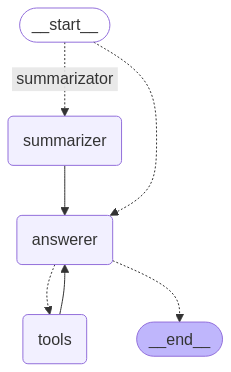

In [43]:
builder = StateGraph(MessagesState)
builder.add_node("summarizer", summarizer)
builder.add_node("answerer", answerer_tools)
builder.add_node("tools", ToolNode(tools))
builder.add_conditional_edges(START, decide_trimmer, {"summarizator":"summarizer","answerer":"answerer" })
builder.add_conditional_edges("answerer",tools_condition)
builder.add_edge("summarizer","answerer")
builder.add_edge("tools","answerer")

memory = MemorySaver() ### Whenever we want to retrieve the state of a graph we need to implement a checkpointer, as seen in Module 2.
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

#### 3.2.- Try the new graph! Make sure to include a thread_id, and work with `get_state` and `command` to resume the flow of the API call confirming its use

In [62]:
thread = {"configurable": {"thread_id": "15"}}
graph.invoke({"messages":[HumanMessage(content="What's the news on Barcelona?")]},thread)

{'messages': [HumanMessage(content="What's the news on Barcelona?", additional_kwargs={}, response_metadata={}, id='5ef5f48e-bd30-4f01-806b-8d85c83c787d')]}

In [63]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content="What's the news on Barcelona?", additional_kwargs={}, response_metadata={}, id='5ef5f48e-bd30-4f01-806b-8d85c83c787d')]}, next=('human_feedback',), config={'configurable': {'thread_id': '15', 'checkpoint_ns': '', 'checkpoint_id': '1f00324c-be62-629f-8001-350360dd50cf'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '15', 'step': 1, 'parents': {}}, created_at='2025-03-17T11:41:42.304835+00:00', parent_config={'configurable': {'thread_id': '15', 'checkpoint_ns': '', 'checkpoint_id': '1f00324c-be55-6fe4-8000-f984bacbed12'}}, tasks=(PregelTask(id='b4e564d2-e2d7-4362-6cf5-8e3cbb592e2e', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),))

In [61]:
graph.invoke(Command(resume="Y"), thread) ### resume is the value that takes the interrupt on the original function.

InvalidUpdateError: Must write to at least one of ['messages']

### 4.- We'd also like to check that the users are spelling the names of the cities correctly, or using the proper tools. Modify the query of the user *before* the graph uses the tool.

**IMPORTANT**: use a different thread_id from previous exercises.

Use `stream` so you can follow in a clearer way what's happening to each node.

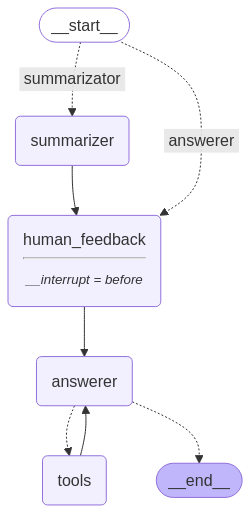

In [47]:
def human_feedback(state: MessagesState):
    pass

builder = StateGraph(MessagesState)
builder.add_node("summarizer", summarizer)
builder.add_node("answerer", answerer_tools)
builder.add_node("human_feedback",human_feedback)
builder.add_node("tools", ToolNode(tools))
builder.add_conditional_edges(START, decide_trimmer, {"summarizator":"summarizer","answerer":"human_feedback" })
builder.add_conditional_edges("answerer",tools_condition)
builder.add_edge("human_feedback","answerer")
builder.add_edge("summarizer","human_feedback")
builder.add_edge("tools","answerer")

memory = MemorySaver() ### Whenever we want to retrieve the state of a graph we need to implement a checkpointer, as seen in Module 2.
graph = builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
thread_4 = {"configurable": {"thread_id": "ex_4e"}}
for event in graph.stream({"messages":[HumanMessage(content="What's the news on Barcelona?")]},thread_4,stream_mode="values"):
    print(event)

{'messages': [HumanMessage(content="What's the news on Barcelona?", additional_kwargs={}, response_metadata={}, id='ba6fda79-6a57-4d18-84ac-8a5f193a8833')]}


In [49]:
graph.update_state(thread_4, {"messages": HumanMessage(content=input("What should be the actual query?"),
                                                       id=[state for state in graph.get_state_history(thread_4)][-2].values['messages'][0].id)}, 
                                                       as_node="human_feedback")
for event in graph.stream(None,thread_4,stream_mode="updates"):
    print(event)

{'answerer': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 3.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-7c1b9f4d-305a-4a81-8fb5-c763ce72fdc7-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3.0, 'b': 3.0}, 'id': '0f660efa-e97a-4bad-8180-a1c3fae309cb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 176, 'output_tokens': 3, 'total_tokens': 179, 'input_token_details': {'cache_read': 0}})}}
{'tools': {'messages': [ToolMessage(content='9', name='multiply', id='4fe3d9d8-2d15-4a51-b703-2dea6c265f2b', tool_call_id='0f660efa-e97a-4bad-8180-a1c3fae309cb')]}}
{'answerer': {'messages': AIMessage(content='Nine.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-adfe12e2-a523-4e1c-803b-7d30293d3a66-0', usage

**Explanation**: the key for this exercise is to access to the id of the original message and modify it with the new query in the `update_state`. That's why we use the list comprehension, where we travel to the id of the message we want to modify. Below you can find a more digestable code:

In [50]:
history = [state for state in graph.get_state_history(thread_4)]
history[-2].values['messages'][0].id

'ba6fda79-6a57-4d18-84ac-8a5f193a8833'

A simpler way can be made with the `get_state`:

In [51]:
graph.get_state(thread_4).values['messages'][0].id

'ba6fda79-6a57-4d18-84ac-8a5f193a8833'

So the list comprehension isn't needed.

### 5.- Use the `get_state_history` to get all the snapshots of the original thread.

In [73]:
history = [state for state in graph.get_state_history(thread)]

In [84]:
history

[StateSnapshot(values={'messages': [HumanMessage(content="What's the news on Barcelona?", additional_kwargs={}, response_metadata={}, id='5ef5f48e-bd30-4f01-806b-8d85c83c787d')]}, next=('human_feedback',), config={'configurable': {'thread_id': '15', 'checkpoint_ns': '', 'checkpoint_id': '1f00324c-be62-629f-8001-350360dd50cf'}}, metadata={'source': 'loop', 'writes': None, 'thread_id': '15', 'step': 1, 'parents': {}}, created_at='2025-03-17T11:41:42.304835+00:00', parent_config={'configurable': {'thread_id': '15', 'checkpoint_ns': '', 'checkpoint_id': '1f00324c-be55-6fe4-8000-f984bacbed12'}}, tasks=(PregelTask(id='b4e564d2-e2d7-4362-6cf5-8e3cbb592e2e', name='human_feedback', path=('__pregel_pull', 'human_feedback'), error=None, interrupts=(), state=None, result=None),)),
 StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '15', 'checkpoint_ns': '', 'checkpoint_id': '1f00324c-be55-6fe4-8000-f984bacbed12'}}, metadata={'source': 'input', 'write

#### 5.1.- Replay the whole thread. How much time did you need? More or less than the original execution?

In [ ]:
graph.invoke(None, history[0].config)

#### 5.2.- Now execute the thread with a new `checkpoint_id` and a new `HumanMessage`. More or less than the run on 5.1?

In [85]:
graph.update_state(history[0].config, {"messages": [HumanMessage(content="Multiply 3 by 12",id=history[0].values["messages"][0].id)]})

{'configurable': {'thread_id': '15',
  'checkpoint_ns': '',
  'checkpoint_id': '1f00326e-ddc2-6c8d-8002-f2f3aeb5c11a'}}